# Metric results comp notebook
This notebook just calcs and compares metrics of different models preds on the test set

In [1]:
import torch
import os
import sys
import torchmetrics
import torch
import pandas as pd
import sumolib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json

In [2]:
sys.path.append('..')
from util_folder.ml_utils.data_utils.data_loader_utils import IncidentDataModule
from util_folder.ml_utils.result_utils.plot_utils import plotNet
from util_folder.dotdict import DotDict
from util_folder.ml_utils.result_utils.metric_utils import (generate_masks, 
                                                            MetricObj, 
                                                            calc_aggregates, 
                                                            create_res_df, 
                                                            create_test_metrics)
from util_folder.ml_utils.result_utils.plot_utils import plot_classification_errors, plot_net_w_logits

In [3]:
def print_res_dict(res_dict, model):
    print(f'************  Results for: {model}  ************')
    for loss_part in res_dict.keys():
        print(f'##{loss_part}:##')
        metric_str = ''
        for metric in res_dict[loss_part].keys():
            metric_str +=  f'{metric} : {res_dict[loss_part][metric]:.02f} \t'
        print(metric_str)

In [4]:
base_dir = '/home/manity/Quick_adap/quick_adap_to_incidents/saved_models/baseline_comp_5min/'
os.listdir(base_dir)

['mlp', 'lstm', 'attention', 'tcn', 'dcrnn']

In [5]:

model_names = ['mlp', 'lstm', 'attention', 'tcn', 'dcrnn']
random_seeds = [41,42,43,44]

y_true = torch.load(f'{base_dir}/{model_names[0]}/y_true_{random_seeds[0]}.pt').cpu()

In [6]:
results_dict = {}
for name in model_names:
    results_dict[name] = {}
    for seed in random_seeds:
        results_dict[name][seed] = torch.load(f'{base_dir}/{name}/y_hat_{seed}.pt').cpu()
        assert (torch.load(f'{base_dir}/{name}/y_true_{seed}.pt').cpu() - y_true).sum() == 0

In [7]:
# Load net and dataset info
folder_path = f'../Simulation_scenarios/motorway/Results/incident_large_long'
incident_data_module = IncidentDataModule(folder_path = folder_path, batch_size = 100)
incident_data_module.setup()
test_dataloader = incident_data_module.test_dataloader()
test_dataset = test_dataloader.dataset

net_path = '../Simulation_scenarios/motorway/Simulations/Base/network.net.xml'
net = sumolib.net.readNet(net_path)

with open('../Simulation_scenarios/motorway/Results/incident_large/ind_to_edge.json') as f:
    ind_to_edge = json.load(f)

# Generate masks for subbsets
upstream_mask, multilane_mask, highway_mask, spreading_mask, affected_mask  = generate_masks(test_dataset)

*** DATA SUMMARY: ***
input_full.shape=torch.Size([10270, 147, 6, 15, 5])
target_full.shape=torch.Size([10270, 147, 4])
incident_info_full.shape=torch.Size([10270, 4])
network_info_full.shape=torch.Size([10270, 147, 13])



In [8]:
metric_obj = MetricObj(bce_pos_weight=25.5191)

full_test = {}
for model in model_names:
    full_test[model] = {}
    for seed in random_seeds:
        full_test[model][seed] = metric_obj.calc_metrics(y_hat=results_dict[model][seed], y_true=y_true)
full_test_aggregates = calc_aggregates(full_test, model_names, random_seeds)
full_test_df = create_res_df(full_test_aggregates)
del full_test

upstream_test_df, not_upstream_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, upstream_mask)
multilane_test_df, not_multilane_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, multilane_mask)
highway_test_df, not_highway_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, highway_mask)
spreading_test_df, not_spreading_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, spreading_mask)
affected_test_df, not_affected_test_df = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, affected_mask)

In [9]:
n_hop_dfs = {}
for hop in range(11):
    n_hop_mask = (test_dataset.network_info[:,:,0] == -hop)
    temp_df, _ = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, n_hop_mask)
    n_hop_dfs[hop] = temp_df

In [10]:
affected_n_hop_dfs = {}
for hop in range(11):
    affected_n_hop_mask = (test_dataset.network_info[:,:,0] == -hop) & affected_mask
    temp_df, _ = create_test_metrics(model_names, random_seeds, metric_obj, results_dict, y_true, affected_n_hop_mask)
    affected_n_hop_dfs[hop] = temp_df

In [11]:
df_arr = [full_test_df,
          upstream_test_df, not_upstream_test_df,
          multilane_test_df, not_multilane_test_df, 
          highway_test_df, not_highway_test_df, 
          spreading_test_df, not_spreading_test_df]


In [12]:

def print_res_df(res_dict, model):
    print(f'************  Results for: {model}  ************')
    for loss_part in res_dict.keys().get_level_values(0).unique():
        print(f'##{loss_part}:##')
        metric_str = ''
        for metric in res_dict[loss_part].keys():
            mean = res_dict[loss_part][metric]["mean"]
            std = res_dict[loss_part][metric]["std"]
            metric_str +=  f'{metric} : {mean:.03f} ({std:.03f}) \t'
        print(metric_str)

In [13]:
#for model in full_test_df.keys().get_level_values(0):
    #print_res_dict(full_test_df[model], model)
pd.set_option('display.max_rows', 500)
full_test_df.T

mean           std
mlp       end   mae    3.017775e+00      0.080087
                mape   9.711138e+05  73286.765625
                Mmape  7.273693e-01      0.003406
          start mae    1.031507e+00      0.030228
                mape   3.105478e+05  24992.164062
                Mmape  7.277008e-01      0.006144
          speed mae    8.946180e-01      0.030409
                mape   2.749328e+05  23536.953125
                Mmape  6.938608e-01      0.004875
          class acc    9.103855e-01      0.005882
                f1     2.225195e-01      0.012620
                prcsn  2.297951e-01      0.011714
                rcll   5.837437e-01      0.013695
lstm      end   mae    2.937229e+00      0.061921
                mape   8.602274e+05  46991.832031
                Mmape  7.538267e-01      0.008788
          start mae    9.883709e-01      0.023127
                mape   2.588803e+05  21931.177734
                Mmape  7.678309e-01      0.004752
          speed mae    8.696767e-01      0.011713
                mape   2.300476e+05   8546.125977
                Mmape  7.261325e-01      0.001749
          class acc    9.204398e-01      0.004975
                f1     2.793694e-01      0.014780
                prcsn  2.530619e-01      0.012481
                rcll   5.671665e-01      0.012465
attention end   mae    2.737959e+00      0.036375
                mape   7.696486e+05  40579.078125
                Mmape  7.254125e-01      0.003888
          start mae    9.781793e-01      0.008967
                mape   2.563375e+05   6327.453125
                Mmape  7.555592e-01      0.010522
          speed mae    8.202677e-01      0.015256
                mape   2.078817e+05   5945.526855
                Mmape  7.004114e-01      0.012853
          class acc    9.227582e-01      0.004953
                f1     2.605993e-01      0.007582
                prcsn  2.577509e-01      0.013341
                rcll   5.561736e-01      0.012452
tcn       end   mae    2.833651e+00      0.091786
                mape   8.408353e+05  75970.343750
                Mmape  7.253373e-01      0.004115
          start mae    1.000899e+00      0.028558
                mape   2.756071e+05  25472.359375
                Mmape  7.565816e-01      0.002946
          speed mae    8.642319e-01      0.026444
                mape   2.363165e+05  26095.253906
                Mmape  7.135454e-01      0.010818
          class acc    9.191167e-01      0.007282
                f1     2.470760e-01      0.016327
                prcsn  2.478364e-01      0.016221
                rcll   5.584821e-01      0.018792
dcrnn     end   mae    4.217182e+00      0.088640
                mape   1.658310e+06  79980.781250
                Mmape  9.129459e-01      0.003008
          start mae    1.325001e+00      0.029943
                mape   5.059071e+05  28196.851562
                Mmape  8.981676e-01      0.004467
          speed mae    1.269479e+00      0.022794
                mape   4.260585e+05  20202.769531
                Mmape  9.301481e-01      0.003142
          class acc    8.307401e-01      0.004693
                f1     1.501460e-01      0.008248
                prcsn  1.038119e-01      0.002924
                rcll   4.577654e-01      0.019100

# MLP

In [14]:
focus_model = 'mlp'

In [15]:
full_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  3.017775  971113.812500  0.727369  1.031507  310547.843750  0.727701   
std   0.080087   73286.765625  0.003406  0.030228   24992.164062  0.006144   

         speed                              class                               
           mae           mape     Mmape       acc       f1     prcsn      rcll  
mean  0.894618  274932.812500  0.693861  0.910386  0.22252  0.229795  0.583744  
std   0.030409   23536.953125  0.004875  0.005882  0.01262  0.011714  0.013695

In [16]:
upstream_test_df[focus_model]

end                             start                           \
            mae          mape     Mmape       mae           mape     Mmape   
mean  13.823253  1.220627e+06  0.727369  4.851766  384727.375000  0.727701   
std    0.063308  5.993375e+04  0.003406  0.028319   19461.902344  0.006144   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  4.143757  315717.312500  0.693861  0.803726  0.587021  0.609449   
std   0.046920   19036.421875  0.004875  0.006652  0.007571  0.017831   

                
          rcll  
mean  0.583744  
std   0.013695

In [17]:
not_upstream_test_df[focus_model]

end                        start                          speed  \
           mae         mape Mmape       mae           mape Mmape       mae   
mean  1.083957  926459.3750   NaN  0.347809  297272.218750   NaN  0.313132   
std   0.090688   77511.4375   NaN  0.030640   26188.300781   NaN  0.029070   

                            class                  
             mape Mmape       acc   f1 prcsn rcll  
mean  267633.7500   NaN  0.929474  0.0   0.0  0.0  
std    24846.4375   NaN  0.007286  0.0   0.0  0.0

In [18]:
multilane_test_df[focus_model] 

end                           start                           \
           mae        mape     Mmape       mae           mape     Mmape   
mean  3.734048  935571.125  0.751585  1.268375  298468.531250  0.747153   
std   0.072634   68281.250  0.003307  0.028898   23231.527344  0.006647   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.112248  267703.968750  0.715291  0.907047  0.275533  0.282580   
std   0.028526   21319.511719  0.004565  0.005204  0.011010  0.012407   

                
          rcll  
mean  0.555605  
std   0.013462

In [19]:
not_multilane_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  2.092055  1.017050e+06  0.655307  0.725375  326159.312500  0.669814   
std   0.090637  8.003408e+04  0.004711  0.032001   27396.738281  0.008434   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.613351  284275.437500  0.630089  0.914700  0.146272  0.157128   
std   0.033031   26420.734375  0.006574  0.006762  0.013658  0.009879   

                
          rcll  
mean  0.667482  
std   0.016541

In [20]:
highway_test_df[focus_model] 

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  3.280041  949671.125000  0.747559  1.133027  303405.937500  0.739624   
std   0.074304   68737.328125  0.003630  0.028996   24057.523438  0.004861   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.991209  271221.093750  0.716898  0.909160  0.240003  0.245445   
std   0.029156   22038.833984  0.005225  0.005314  0.010304  0.010560   

                
          rcll  
mean  0.559649  
std   0.014371

In [21]:
not_highway_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  2.584052  1.006575e+06  0.681569  0.863617  322358.812500  0.700654   
std   0.089980  8.107059e+04  0.003137  0.032485   26677.574219  0.009637   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.734881  281071.031250  0.641602  0.912413  0.192165  0.204009   
std   0.033099   26195.208984  0.005473  0.007019  0.016366  0.013990   

                
          rcll  
mean  0.638402  
std   0.015070

In [22]:
spreading_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.280303  1.223536e+06  0.734438  1.466521  391208.062500  0.733580   
std   0.093991  8.791256e+04  0.003598  0.036393   30343.798828  0.005324   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.247916  339300.343750  0.698703  0.884120  0.250236  0.258091   
std   0.035141   26976.611328  0.004855  0.006876  0.012405  0.012081   

                
          rcll  
mean  0.577107  
std   0.013078

In [23]:
not_spreading_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  0.683585  504429.875000  0.570408  0.227242  161421.531250  0.597160   
std   0.055289   46427.535156  0.008470  0.019252   15520.433594  0.028233   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.241433  155928.781250  0.586331  0.958945  0.068114  0.078686   
std   0.022306   17682.683594  0.017265  0.004312  0.009598  0.006526   

                
          rcll  
mean  0.731122  
std   0.042658

In [24]:
affected_test_df[focus_model]

end                          start                          speed  \
            mae      mape     Mmape        mae      mape     Mmape        mae   
mean  49.961998  0.727369  0.727369  17.742023  0.727701  0.727701  15.213647   
std    0.271759  0.003406  0.003406   0.059329  0.006144  0.006144   0.110213   

                             class                            
          mape     Mmape       acc        f1 prcsn      rcll  
mean  0.693861  0.693861  0.583744  0.843368   1.0  0.583744  
std   0.004875  0.004875  0.013695  0.018511   0.0  0.013695

In [25]:
not_affected_test_df[focus_model]

end                       start                          speed  \
           mae        mape Mmape       mae           mape Mmape       mae   
mean  1.180667  1009117.25   NaN  0.377560  322700.750000   NaN  0.334260   
std   0.089101    76154.75   NaN  0.030385   25970.189453   NaN  0.028616   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  285691.937500   NaN  0.923168  0.0   0.0  0.0  
std    24458.035156   NaN  0.006580  0.0   0.0  0.0

In [26]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')


	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.91	 0.85	 0.95	 0.86	 4.96	 19.03	 8.06
1:	 0.90	 0.88	 0.95	 0.85	 4.27	 15.74	 4.91
2:	 0.82	 0.83	 0.93	 0.72	 5.11	 17.00	 5.80
3:	 0.71	 0.76	 0.84	 0.57	 6.09	 19.45	 6.65
4:	 0.67	 0.75	 0.78	 0.48	 6.32	 20.58	 6.87
5:	 0.62	 0.74	 0.69	 0.42	 6.31	 20.78	 6.63
6:	 0.60	 0.75	 0.65	 0.41	 6.47	 20.65	 6.42
7:	 0.60	 0.75	 0.59	 0.39	 6.80	 20.86	 6.28
8:	 0.55	 0.75	 0.52	 0.37	 6.78	 19.38	 5.81
9:	 0.54	 0.76	 0.51	 0.38	 7.26	 19.37	 5.50
10:	 0.51	 0.78	 0.48	 0.41	 7.36	 18.03	 4.95


In [27]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = affected_n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')

	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.94	 0.86	 1.00	 0.86	 5.93	 22.89	 9.74
1:	 0.93	 0.85	 1.00	 0.85	 6.34	 23.40	 7.33
2:	 0.87	 0.72	 1.00	 0.72	 9.64	 32.04	 11.03
3:	 0.80	 0.57	 1.00	 0.57	 13.26	 42.15	 14.69
4:	 0.78	 0.48	 1.00	 0.48	 15.56	 50.66	 17.15
5:	 0.77	 0.42	 1.00	 0.42	 17.63	 58.16	 18.86
6:	 0.77	 0.41	 1.00	 0.41	 19.77	 63.17	 19.84
7:	 0.79	 0.39	 1.00	 0.39	 22.22	 68.03	 20.62
8:	 0.79	 0.37	 1.00	 0.37	 24.74	 70.21	 21.24
9:	 0.80	 0.38	 1.00	 0.38	 28.12	 74.07	 21.14
10:	 0.80	 0.41	 1.00	 0.41	 31.74	 76.14	 20.93


Text(0.5, 1.0, 'mlp')

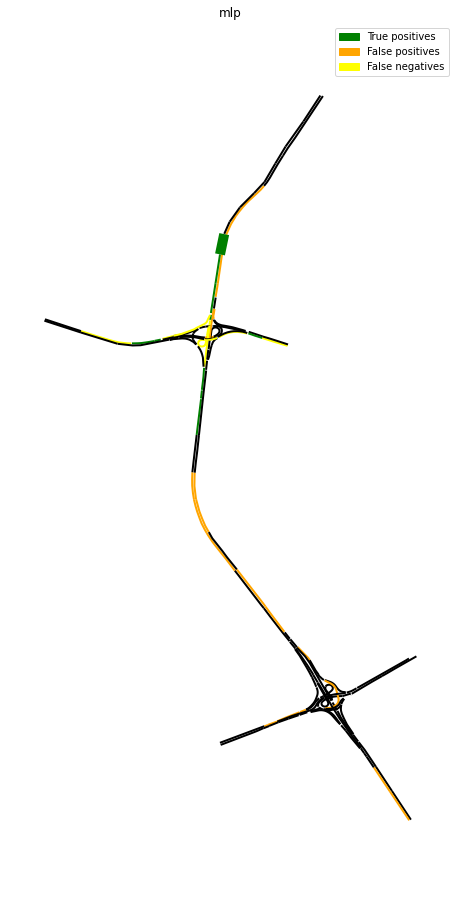

In [28]:
fig, ax = plt.subplots(figsize=(8,16))
plot_classification_errors(y_hat=results_dict[focus_model][41],
y_true=y_true,
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'mlp')

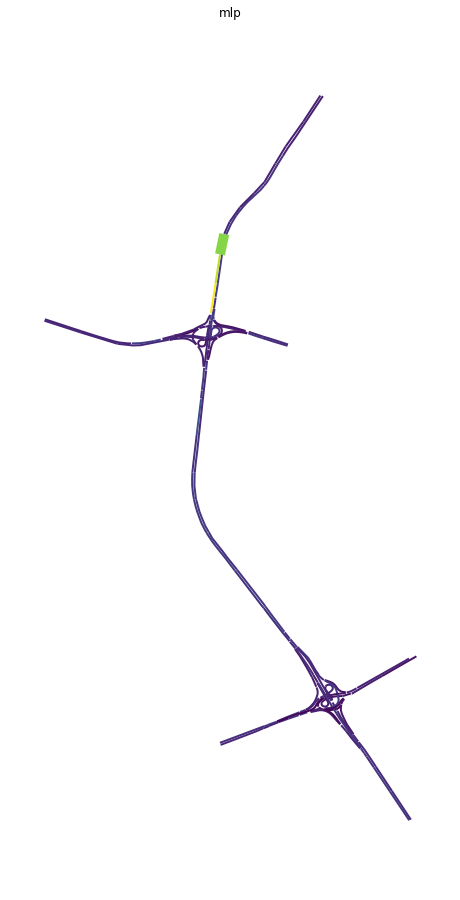

In [29]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=results_dict[focus_model][41],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'False neg')

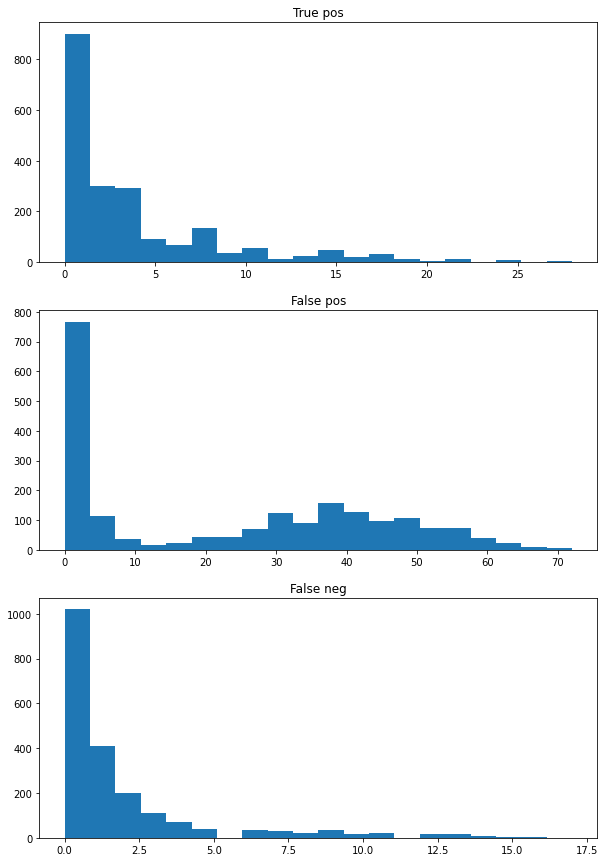

In [30]:
pred_classes = results_dict[focus_model][41][...,0] > 0
true_classes = y_true[...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=20)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=20)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=20)
ax[2].set_title('False neg')



# LSTM

In [31]:
focus_model = 'lstm'

In [32]:
full_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  2.937229  860227.375000  0.753827  0.988371  258880.343750  0.767831   
std   0.061921   46991.832031  0.008788  0.023127   21931.177734  0.004752   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.869677  230047.562500  0.726132  0.920440  0.279369  0.253062   
std   0.011713    8546.125977  0.001749  0.004975  0.014780  0.012481   

                
          rcll  
mean  0.567167  
std   0.012465

In [33]:
upstream_test_df[focus_model]

end                            start                           \
            mae         mape     Mmape       mae           mape     Mmape   
mean  14.067827  1152694.000  0.753827  4.916586  342635.750000  0.767831   
std    0.135870    55655.125  0.008788  0.015207   26816.980469  0.004752   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  4.312671  304831.687500  0.726132  0.810195  0.594843  0.631099   
std   0.028303   13168.485352  0.001749  0.004537  0.004136  0.015332   

                
          rcll  
mean  0.567167  
std   0.012465

In [34]:
not_upstream_test_df[focus_model]

end                          start                          speed  \
           mae           mape Mmape       mae           mape Mmape       mae   
mean  0.945226  807885.687500   NaN  0.285352  243890.937500   NaN  0.253497   
std   0.053415   45653.835938   NaN  0.024749   21152.628906   NaN  0.009439   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  216663.734375   NaN  0.940170  0.0   0.0  0.0  
std     8067.474121   NaN  0.005141  0.0   0.0  0.0

In [35]:
multilane_test_df[focus_model] 

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  3.682154  840159.750000  0.776264  1.241723  251598.671875  0.797933   
std   0.055269   42322.710938  0.006494  0.019499   20056.339844  0.006312   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.101537  227361.140625  0.742754  0.916371  0.333224  0.309398   
std   0.013288    9908.514648  0.001797  0.004339  0.010861  0.012422   

                
          rcll  
mean  0.543179  
std   0.013716

In [36]:
not_multilane_test_df[focus_model]

end                            start                           \
           mae         mape     Mmape       mae           mape     Mmape   
mean  1.974480  886163.0000  0.687055  0.660936  268291.187500  0.678252   
std   0.070609   53540.9375  0.016478  0.028296   24502.109375  0.004078   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.570018  233519.562500  0.676668  0.925698  0.195272  0.173288   
std   0.009962    7030.749512  0.003052  0.005818  0.017953  0.011626   

                
          rcll  
mean  0.638549  
std   0.010518

In [37]:
highway_test_df[focus_model] 

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  3.216860  850456.750000  0.776068  1.101219  255398.187500  0.793063   
std   0.056148   45408.140625  0.003405  0.021536   21342.107422  0.006796   

         speed                              class                               
           mae           mape     Mmape       acc        f1    prcsn      rcll  
mean  0.979299  228281.796875  0.751310  0.918567  0.293472  0.26775  0.540167  
std   0.013490    8938.975586  0.003036  0.004650  0.011823  0.01168  0.014898

In [38]:
not_highway_test_df[focus_model]

end                             start                           \
          mae          mape     Mmape       mae           mape     Mmape   
mean  2.47479  876385.43750  0.703373  0.801749  264638.906250  0.710592   
std   0.07311   49749.28125  0.021065  0.026200   22949.726562  0.006791   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.688390  232967.718750  0.669017  0.923537  0.254355  0.228637   
std   0.009199    8002.819336  0.003019  0.005549  0.020082  0.014117   

                
          rcll  
mean  0.628413  
std   0.008036

In [39]:
spreading_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.191922  1.089808e+06  0.757400  1.417978  327768.781250  0.773780   
std   0.079826  5.945720e+04  0.008755  0.028791   27798.914062  0.004689   

         speed                             class                                
           mae          mape     Mmape       acc        f1     prcsn      rcll  
mean  1.226748  291362.00000  0.726531  0.895742  0.308245  0.282006  0.564539  
std   0.015070   11279.78125  0.001107  0.006214  0.014607  0.013162  0.013235

In [40]:
not_spreading_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  0.617526  435774.500000  0.674482  0.194104  131517.921875  0.635733   
std   0.028871   24552.990234  0.009900  0.012818   11218.713867  0.008027   

         speed                              class                               
           mae           mape     Mmape       acc        f1     prcsn     rcll  
mean  0.209516  116688.156250  0.717278  0.966102  0.093969  0.082896  0.62551  
std   0.005509    3634.032715  0.019850  0.002710  0.010505  0.007416  0.01687

In [41]:
affected_test_df[focus_model]

end                          start                          speed  \
            mae      mape     Mmape        mae      mape     Mmape        mae   
mean  51.268204  0.753827  0.753827  18.201805  0.767831  0.767831  15.945839   
std    0.453005  0.008788  0.008788   0.069648  0.004752  0.004752   0.054160   

                             class                            
          mape     Mmape       acc        f1 prcsn      rcll  
mean  0.726132  0.726132  0.567167  0.794368   1.0  0.567167  
std   0.001749  0.001749  0.012465  0.019331   0.0  0.012465

In [42]:
not_affected_test_df[focus_model]

end                          start                          speed  \
           mae           mape Mmape       mae           mape Mmape       mae   
mean  1.045853  893891.375000   NaN  0.314743  269011.312500   NaN  0.279689   
std   0.057132   48830.765625   NaN  0.026664   22789.433594   NaN  0.010390   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  239050.187500   NaN  0.934265  0.0   0.0  0.0  
std     8880.566406   NaN  0.005622  0.0   0.0  0.0

In [43]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')


	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.89	 0.80	 0.96	 0.79	 5.76	 21.89	 10.40
1:	 0.89	 0.86	 0.97	 0.82	 5.21	 17.38	 5.96
2:	 0.82	 0.83	 0.95	 0.70	 5.41	 17.39	 6.24
3:	 0.70	 0.77	 0.87	 0.54	 6.10	 19.33	 6.86
4:	 0.62	 0.74	 0.80	 0.45	 6.32	 20.90	 6.99
5:	 0.58	 0.74	 0.72	 0.40	 6.24	 21.13	 6.64
6:	 0.58	 0.76	 0.68	 0.40	 6.42	 20.94	 6.41
7:	 0.57	 0.77	 0.65	 0.41	 6.74	 20.94	 6.23
8:	 0.54	 0.77	 0.58	 0.40	 6.74	 19.45	 5.77
9:	 0.52	 0.77	 0.54	 0.40	 7.22	 19.32	 5.45
10:	 0.52	 0.79	 0.51	 0.43	 7.35	 18.07	 4.90


In [44]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = affected_n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')

	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.91	 0.79	 1.00	 0.79	 7.00	 26.66	 12.77
1:	 0.91	 0.82	 1.00	 0.82	 7.84	 26.10	 8.99
2:	 0.85	 0.70	 1.00	 0.70	 10.31	 33.06	 11.94
3:	 0.75	 0.54	 1.00	 0.54	 13.48	 42.53	 15.23
4:	 0.69	 0.45	 1.00	 0.45	 15.68	 51.82	 17.45
5:	 0.68	 0.40	 1.00	 0.40	 17.65	 59.76	 18.91
6:	 0.70	 0.40	 1.00	 0.40	 19.77	 64.42	 19.84
7:	 0.71	 0.41	 1.00	 0.41	 22.18	 68.63	 20.55
8:	 0.71	 0.40	 1.00	 0.40	 24.81	 70.86	 21.17
9:	 0.72	 0.40	 1.00	 0.40	 28.17	 74.27	 21.04
10:	 0.75	 0.43	 1.00	 0.43	 31.85	 76.53	 20.80


Text(0.5, 1.0, 'lstm')

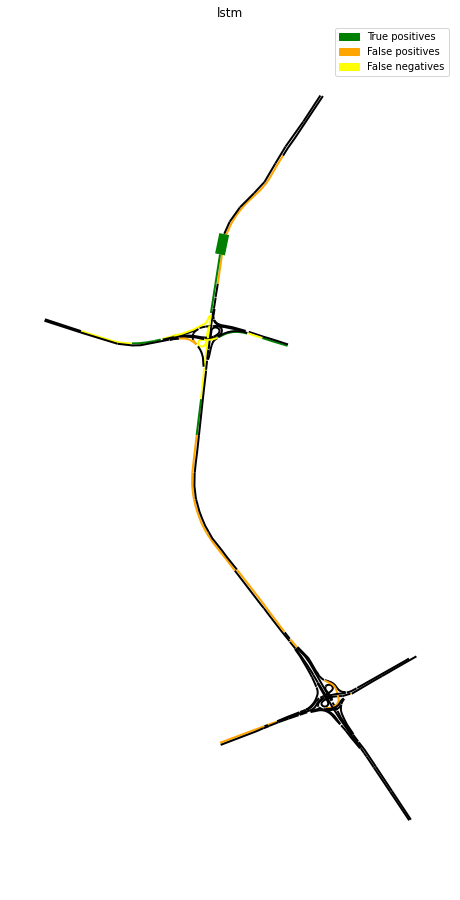

In [45]:
fig, ax = plt.subplots(figsize=(8,16))
plot_classification_errors(y_hat=results_dict[focus_model][41],
y_true=y_true,
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'lstm')

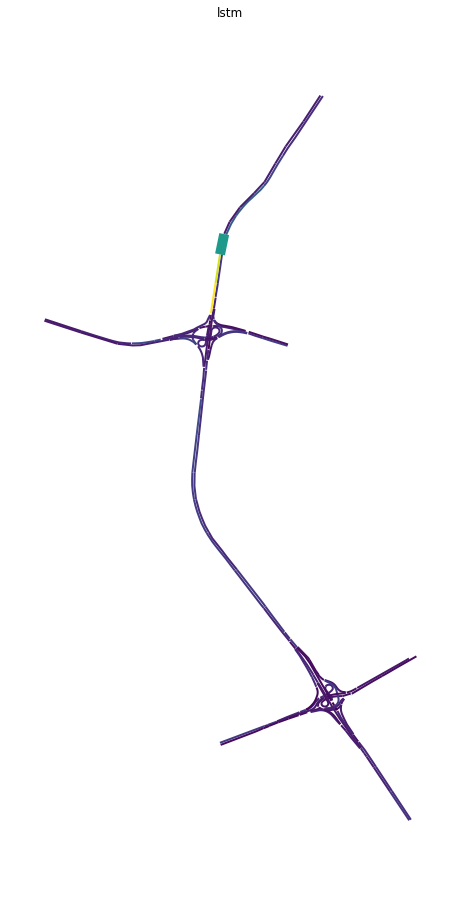

In [46]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=results_dict[focus_model][41],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'False neg')

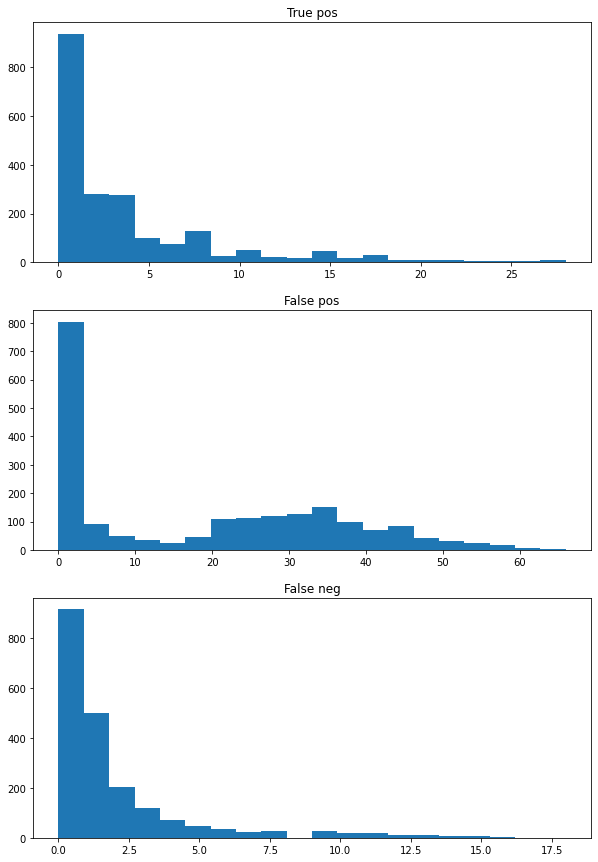

In [47]:
pred_classes = results_dict[focus_model][41][...,0] > 0
true_classes = y_true[...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=20)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=20)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=20)
ax[2].set_title('False neg')



# Attention

In [48]:
focus_model = 'attention'

In [49]:
full_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  2.737959  769648.625000  0.725412  0.978179  256337.531250  0.755559   
std   0.036375   40579.078125  0.003888  0.008967    6327.453125  0.010522   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.820268  207881.656250  0.700411  0.922758  0.260599  0.257751   
std   0.015256    5945.526855  0.012853  0.004953  0.007582  0.013341   

                
          rcll  
mean  0.556174  
std   0.012452

In [50]:
upstream_test_df[focus_model]

end                              start                           \
            mae           mape     Mmape       mae           mape     Mmape   
mean  13.262636  989774.625000  0.725412  4.851753  327854.937500  0.755559   
std    0.020966   55744.714844  0.003888  0.022938   13050.829102  0.010522   

         speed                             class                                
           mae          mape     Mmape       acc        f1     prcsn      rcll  
mean  4.083448  241089.46875  0.700411  0.815148  0.599686  0.649102  0.556174  
std   0.077403   11534.84082  0.012853  0.003716  0.002572  0.014838  0.012452

In [51]:
not_upstream_test_df[focus_model]

end                          start                         speed  \
           mae           mape Mmape       mae          mape Mmape       mae   
mean  0.854397  730253.500000   NaN  0.284940  243538.34375   NaN  0.236268   
std   0.045695   39055.316406   NaN  0.007128    6091.98877   NaN  0.006609   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  201938.593750   NaN  0.942017  0.0   0.0  0.0  
std     5648.823242   NaN  0.005300  0.0   0.0  0.0

In [52]:
multilane_test_df[focus_model] 

end                           start                           \
           mae         mape     Mmape      mae           mape     Mmape   
mean  3.454411  747159.9375  0.747600  1.22244  247091.953125  0.776294   
std   0.033215   40475.1875  0.004427  0.00987    5759.098633  0.010240   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.042610  204322.093750  0.718866  0.919130  0.314118  0.317106   
std   0.017836    6080.242188  0.011745  0.004517  0.008838  0.014472   

                
          rcll  
mean  0.532223  
std   0.016589

In [53]:
not_multilane_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  1.812010  798713.250000  0.659386  0.662494  268286.625000  0.693855   
std   0.040532   41121.753906  0.005490  0.008682    7568.040039  0.013877   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.532910  212482.062500  0.645494  0.927448  0.178991  0.175088   
std   0.012768    6226.459473  0.016883  0.005517  0.005255  0.011403   

                
          rcll  
mean  0.627448  
std   0.006513

In [54]:
highway_test_df[focus_model] 

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  3.021212  756308.062500  0.751405  1.086057  251572.750000  0.772548   
std   0.040126   39632.429688  0.003425  0.011185    6177.143555  0.012854   

         speed                             class                                
           mae          mape     Mmape       acc        f1     prcsn      rcll  
mean  0.919679  204342.65625  0.723701  0.921270  0.277662  0.274555  0.530917  
std   0.019023    6160.52832  0.014194  0.004976  0.008911  0.014523  0.012444

In [55]:
not_highway_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  2.269532  791710.625000  0.666449  0.799776  264217.312500  0.717022   
std   0.030624   42255.191406  0.009987  0.007025    6694.344727  0.017703   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.655866  213734.250000  0.647580  0.925218  0.230750  0.230108   
std   0.009579    5623.882324  0.011368  0.004937  0.005694  0.011465   

                
          rcll  
mean  0.613467  
std   0.012806

In [56]:
spreading_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  3.920703  978828.000000  0.729233  1.404996  326360.812500  0.760587   
std   0.041253   52254.148438  0.004972  0.011240    8201.765625  0.009619   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.159855  261313.125000  0.703221  0.898259  0.287373  0.286254   
std   0.020009    7716.093262  0.011373  0.006130  0.007934  0.013386   

                
          rcll  
mean  0.554246  
std   0.015146

In [57]:
not_spreading_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  0.551278  382913.593750  0.640568  0.189072  126877.039062  0.643904   
std   0.028050   19237.078125  0.051924  0.005262    2946.606689  0.045004   

         speed                              class                               
           mae           mape     Mmape       acc        f1     prcsn     rcll  
mean  0.192432  109096.453125  0.638031  0.968053  0.084632  0.084930  0.59898  
std   0.007055    3995.930908  0.063228  0.002863  0.008882  0.015599  0.08242

In [58]:
affected_test_df[focus_model]

end                          start                          speed  \
            mae      mape     Mmape        mae      mape     Mmape        mae   
mean  48.790981  0.725412  0.725412  18.010185  0.755559  0.755559  15.322503   
std    0.337952  0.003888  0.003888   0.120371  0.010522  0.010522   0.298175   

                             class                            
          mape     Mmape       acc        f1 prcsn      rcll  
mean  0.700411  0.700411  0.556174  0.793575   1.0  0.556174  
std   0.012853  0.012853  0.012452  0.010285   0.0  0.012452

In [59]:
not_affected_test_df[focus_model]

end                          start                          speed  \
           mae           mape Mmape       mae           mape Mmape       mae   
mean  0.935728  799767.937500   NaN  0.311652  266369.000000   NaN  0.252740   
std   0.049336   42167.152344   NaN  0.007693    6575.071289   NaN  0.007228   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  216016.843750   NaN  0.937104  0.0   0.0  0.0  
std     6178.212891   NaN  0.005494  0.0   0.0  0.0

In [60]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')


	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.88	 0.79	 0.96	 0.78	 5.38	 19.79	 9.05
1:	 0.89	 0.86	 0.97	 0.82	 4.55	 14.96	 5.06
2:	 0.81	 0.82	 0.95	 0.70	 5.28	 15.99	 5.73
3:	 0.69	 0.76	 0.86	 0.53	 6.22	 18.58	 6.61
4:	 0.63	 0.74	 0.79	 0.44	 6.43	 19.87	 6.81
5:	 0.58	 0.75	 0.73	 0.39	 6.30	 19.67	 6.47
6:	 0.57	 0.75	 0.68	 0.39	 6.46	 19.63	 6.28
7:	 0.56	 0.76	 0.65	 0.37	 6.80	 20.04	 6.15
8:	 0.55	 0.77	 0.58	 0.37	 6.75	 18.73	 5.65
9:	 0.53	 0.78	 0.56	 0.39	 7.19	 18.72	 5.36
10:	 0.52	 0.79	 0.53	 0.41	 7.28	 17.59	 4.82


In [61]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = affected_n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')

	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.90	 0.78	 1.00	 0.78	 6.50	 23.93	 10.97
1:	 0.91	 0.82	 1.00	 0.82	 6.83	 22.42	 7.60
2:	 0.84	 0.70	 1.00	 0.70	 10.01	 30.23	 10.93
3:	 0.75	 0.53	 1.00	 0.53	 13.66	 40.55	 14.70
4:	 0.71	 0.44	 1.00	 0.44	 15.93	 49.15	 17.08
5:	 0.69	 0.39	 1.00	 0.39	 17.78	 55.44	 18.55
6:	 0.70	 0.39	 1.00	 0.39	 19.87	 60.29	 19.59
7:	 0.70	 0.37	 1.00	 0.37	 22.34	 65.64	 20.41
8:	 0.72	 0.37	 1.00	 0.37	 24.86	 68.46	 20.94
9:	 0.71	 0.39	 1.00	 0.39	 28.16	 72.66	 20.98
10:	 0.75	 0.41	 1.00	 0.41	 31.62	 75.25	 20.78


Text(0.5, 1.0, 'attention')

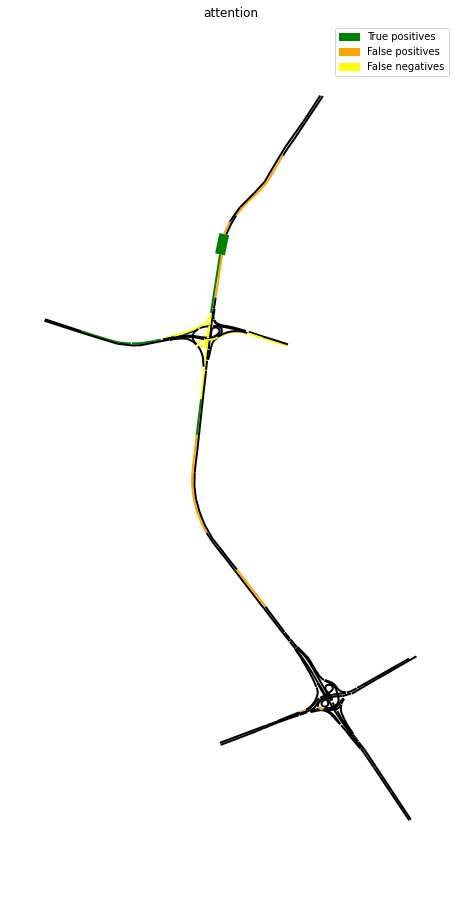

In [62]:
fig, ax = plt.subplots(figsize=(8,16))
plot_classification_errors(y_hat=results_dict[focus_model][41],
y_true=y_true,
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'attention')

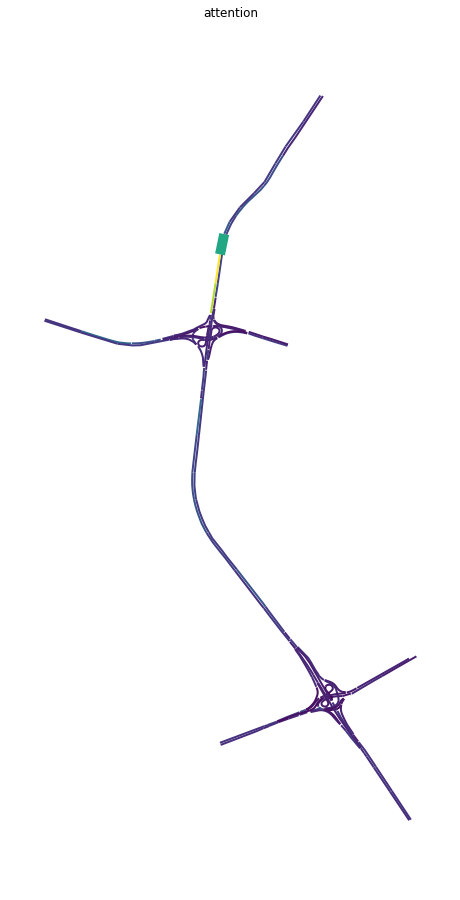

In [63]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=results_dict[focus_model][41],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'False neg')

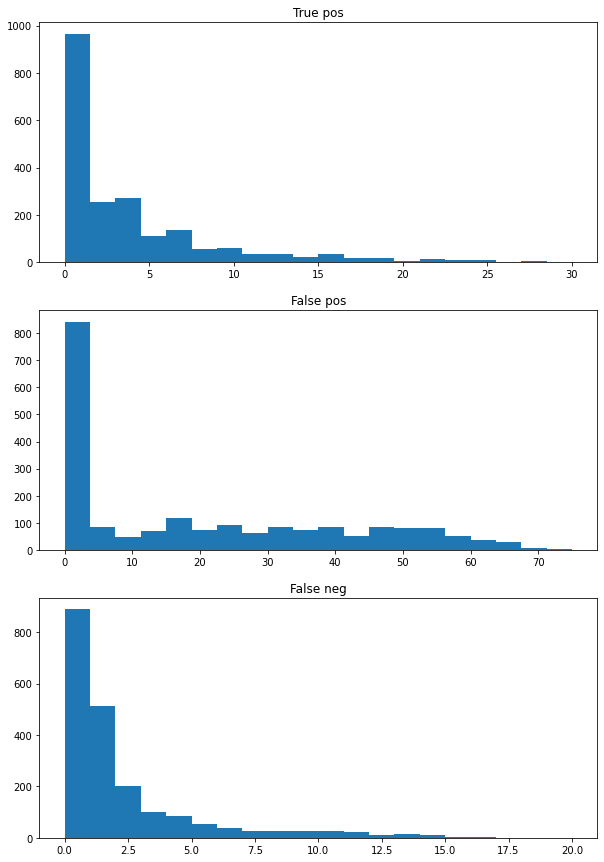

In [64]:
pred_classes = results_dict[focus_model][41][...,0] > 0
true_classes = y_true[...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=20)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=20)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=20)
ax[2].set_title('False neg')



# TCN

In [65]:
focus_model = 'tcn'

In [66]:
full_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  2.833651  840835.31250  0.725337  1.000899  275607.062500  0.756582   
std   0.091786   75970.34375  0.004115  0.028558   25472.359375  0.002946   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.864232  236316.484375  0.713545  0.919117  0.247076  0.247836   
std   0.026444   26095.253906  0.010818  0.007282  0.016327  0.016221   

                
          rcll  
mean  0.558482  
std   0.018792

In [67]:
upstream_test_df[focus_model]

end                             start                           \
            mae          mape     Mmape       mae           mape     Mmape   
mean  13.483621  1.108816e+06  0.725337  4.889944  359516.312500  0.756582   
std    0.118115  6.284487e+04  0.004115  0.013941   18954.380859  0.002946   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  4.185465  268062.625000  0.713545  0.805346  0.587251  0.619827   
std   0.044745   25392.671875  0.010818  0.002019  0.003307  0.010169   

                
          rcll  
mean  0.558482  
std   0.018792

In [68]:
not_upstream_test_df[focus_model]

end                        start                          speed  \
           mae         mape Mmape       mae           mape Mmape       mae   
mean  0.927665  792875.8750   NaN  0.304890  260590.156250   NaN  0.269843   
std   0.091667   78347.9375   NaN  0.031503   26925.269531   NaN  0.030889   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  230635.000000   NaN  0.939478  0.0   0.0  0.0  
std    26400.892578   NaN  0.008283  0.0   0.0  0.0

In [69]:
multilane_test_df[focus_model] 

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  3.550516  820349.500000  0.746435  1.244557  267396.937500  0.772894   
std   0.090450   72445.632812  0.005195  0.027573   24312.941406  0.003869   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.091216  234438.375000  0.731230  0.914815  0.297914  0.302202   
std   0.025053   26005.238281  0.010121  0.006831  0.017895  0.018563   

                
          rcll  
mean  0.531665  
std   0.017735

In [70]:
not_multilane_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  1.907166  867311.562500  0.662553  0.685992  286217.937500  0.708038   
std   0.094136   80672.523438  0.002988  0.029847   26979.103516  0.006703   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.570875  238743.781250  0.660919  0.924677  0.170319  0.171409   
std   0.029115   26385.208984  0.013613  0.007890  0.012742  0.012266   

                
          rcll  
mean  0.638287  
std   0.022636

In [71]:
highway_test_df[focus_model] 

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  3.107155  830473.500000  0.745664  1.105592  271695.312500  0.763616   
std   0.084404   71830.703125  0.004937  0.026982   24386.667969  0.003842   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.966557  235193.437500  0.735489  0.916866  0.261378  0.260663   
std   0.023348   25617.640625  0.011859  0.006528  0.016208  0.014816   

                
          rcll  
mean  0.530347  
std   0.019140

In [72]:
not_highway_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  2.381345  857971.312500  0.679228  0.827763  282076.125000  0.740623   
std   0.104191   83531.664062  0.003502  0.031310   27481.966797  0.003136   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.695012  238173.718750  0.663767  0.922839  0.221886  0.226395   
std   0.032265   27345.560547  0.011043  0.008599  0.016682  0.018579   

                
          rcll  
mean  0.622305  
std   0.018184

In [73]:
spreading_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.040678  1.063263e+06  0.730348  1.431638  349120.312500  0.761126   
std   0.117074  9.607772e+04  0.004757  0.036233   32272.882812  0.001960   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.212591  292158.500000  0.716792  0.894489  0.274096  0.276992   
std   0.031819   32675.527344  0.010459  0.008936  0.016467  0.017288   

                
          rcll  
mean  0.553281  
std   0.019300

In [74]:
not_spreading_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  0.602076  429606.750000  0.614068  0.204540  139694.234375  0.655676   
std   0.045142   39073.621094  0.010548  0.014591   13110.965820  0.026990   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.220178  133074.609375  0.641462  0.964649  0.081423  0.084933   
std   0.016682   14654.065430  0.020900  0.004231  0.009174  0.008402   

                
          rcll  
mean  0.673980  
std   0.039831

In [75]:
affected_test_df[focus_model]

end                          start                          speed  \
            mae      mape     Mmape        mae      mape     Mmape        mae   
mean  49.120323  0.725337  0.725337  18.014807  0.756582  0.756582  15.606501   
std    0.343995  0.004115  0.004115   0.040556  0.002946  0.002946   0.248076   

                             class                            
          mape     Mmape       acc        f1 prcsn      rcll  
mean  0.713545  0.713545  0.558482  0.804759   1.0  0.558482  
std   0.010818  0.010818  0.018792  0.017684   0.0  0.018792

In [76]:
not_affected_test_df[focus_model]

end                          start                          speed  \
           mae           mape Mmape       mae           mape Mmape       mae   
mean  1.022276  873740.500000   NaN  0.335079  286392.625000   NaN  0.287310   
std   0.092364   78943.398438   NaN  0.030969   26469.179688   NaN  0.031726   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  245564.421875   NaN  0.933230  0.0   0.0  0.0  
std    27116.460938   NaN  0.008274  0.0   0.0  0.0

In [77]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')


	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.90	 0.83	 0.95	 0.84	 5.31	 18.63	 8.66
1:	 0.89	 0.86	 0.97	 0.82	 4.73	 15.26	 5.57
2:	 0.80	 0.82	 0.94	 0.68	 5.42	 16.52	 6.19
3:	 0.69	 0.75	 0.86	 0.52	 6.22	 18.95	 6.82
4:	 0.63	 0.74	 0.79	 0.44	 6.37	 20.23	 6.94
5:	 0.59	 0.74	 0.72	 0.39	 6.31	 20.09	 6.56
6:	 0.58	 0.75	 0.66	 0.40	 6.45	 19.95	 6.35
7:	 0.56	 0.75	 0.61	 0.37	 6.83	 20.45	 6.24
8:	 0.54	 0.76	 0.56	 0.38	 6.77	 18.98	 5.75
9:	 0.52	 0.77	 0.54	 0.38	 7.21	 18.91	 5.42
10:	 0.51	 0.78	 0.51	 0.40	 7.30	 17.76	 4.89


In [78]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = affected_n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')

	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.93	 0.84	 1.00	 0.84	 6.38	 22.38	 10.49
1:	 0.91	 0.82	 1.00	 0.82	 7.11	 22.92	 8.42
2:	 0.84	 0.68	 1.00	 0.68	 10.29	 31.29	 11.84
3:	 0.75	 0.52	 1.00	 0.52	 13.63	 41.26	 15.14
4:	 0.72	 0.44	 1.00	 0.44	 15.74	 49.95	 17.39
5:	 0.71	 0.39	 1.00	 0.39	 17.71	 56.42	 18.76
6:	 0.72	 0.40	 1.00	 0.40	 19.81	 61.32	 19.80
7:	 0.72	 0.37	 1.00	 0.37	 22.32	 66.65	 20.57
8:	 0.74	 0.38	 1.00	 0.38	 24.72	 68.73	 21.10
9:	 0.73	 0.38	 1.00	 0.38	 28.10	 72.69	 20.98
10:	 0.75	 0.40	 1.00	 0.40	 31.61	 75.45	 20.92


Text(0.5, 1.0, 'tcn')

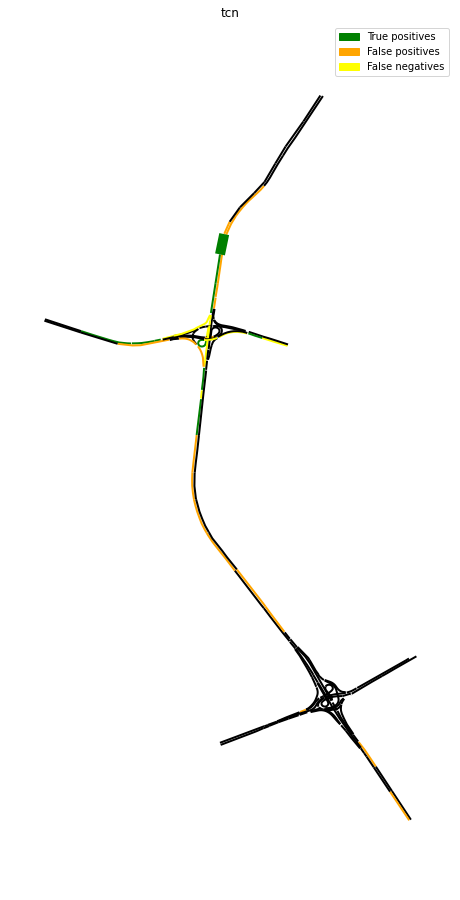

In [79]:
fig, ax = plt.subplots(figsize=(8,16))
plot_classification_errors(y_hat=results_dict[focus_model][41],
y_true=y_true,
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'tcn')

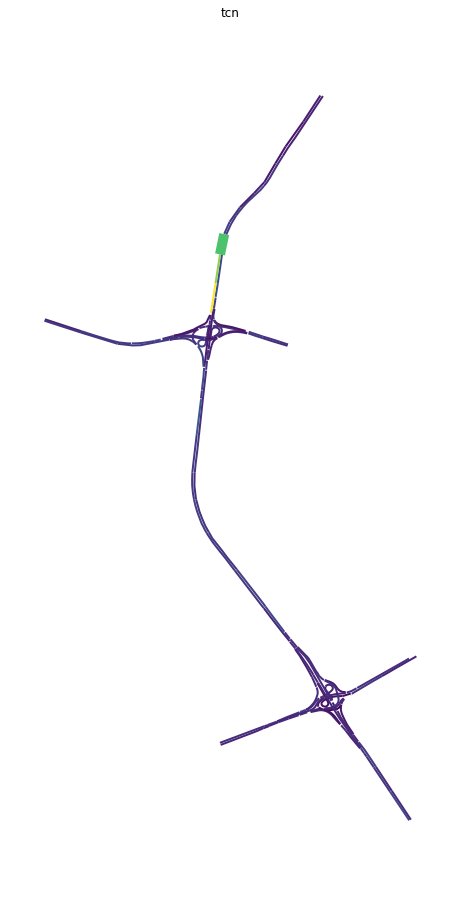

In [80]:
fig, ax = plt.subplots(figsize=(8,16))
plot_net_w_logits(y_hat=results_dict[focus_model][41],
                  seq_num=6,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'False neg')

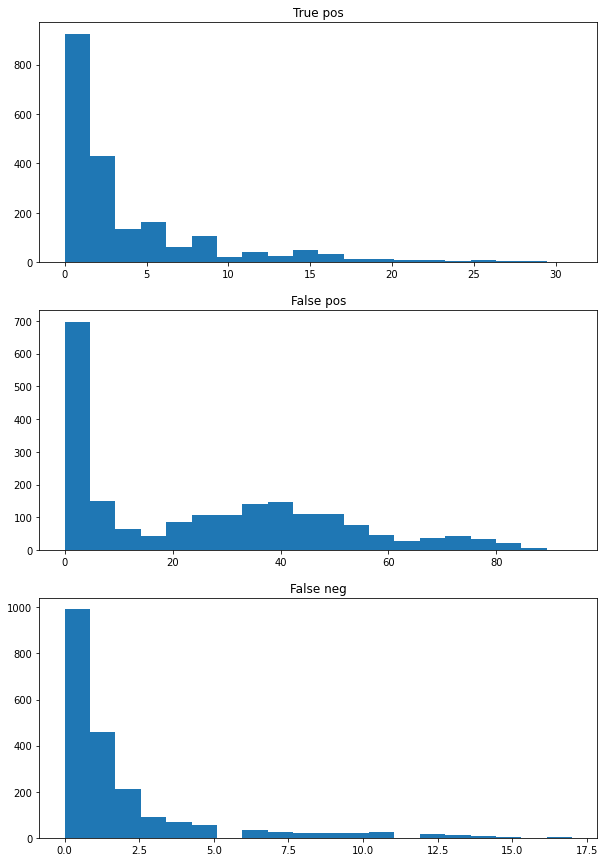

In [81]:
pred_classes = results_dict[focus_model][41][...,0] > 0
true_classes = y_true[...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=20)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=20)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=20)
ax[2].set_title('False neg')



# DCRNN

In [82]:
focus_model = 'dcrnn'

In [83]:
full_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.217182  1.658310e+06  0.912946  1.325001  505907.093750  0.898168   
std   0.088640  7.998078e+04  0.003008  0.029943   28196.851562  0.004467   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.269479  426058.468750  0.930148  0.830740  0.150146  0.103812   
std   0.022794   20202.769531  0.003142  0.004693  0.008248  0.002924   

                
          rcll  
mean  0.457765  
std   0.019100

In [84]:
upstream_test_df[focus_model]

end                             start                           \
            mae          mape     Mmape       mae           mape     Mmape   
mean  17.531626  2.163958e+06  0.912946  5.603836  661970.000000  0.898168   
std    0.041433  6.005214e+04  0.003008  0.008217   24840.123047  0.004467   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  5.692420  524285.500000  0.930148  0.670267  0.448767  0.367821   
std   0.005161   18720.787109  0.003142  0.004622  0.010452  0.003813   

                
          rcll  
mean  0.457765  
std   0.019100

In [85]:
not_upstream_test_df[focus_model]

end                        start                          speed  \
           mae         mape Mmape       mae           mape Mmape       mae   
mean  1.834344  1567815.500   NaN  0.559233  477977.093750   NaN  0.477921   
std   0.099734    85242.875   NaN  0.034223   29250.458984   NaN  0.026369   

                              class                  
               mape Mmape       acc   f1 prcsn rcll  
mean  408479.156250   NaN  0.859459  0.0   0.0  0.0  
std    22537.978516   NaN  0.004913  0.0   0.0  0.0

In [86]:
multilane_test_df[focus_model] 

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  4.961333  1.582685e+06  0.912752  1.554864  483211.125000  0.896732   
std   0.085089  7.834009e+04  0.003039  0.027804   27582.269531  0.005048   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.531427  407733.718750  0.929728  0.831569  0.197449  0.142678   
std   0.021497   19262.642578  0.003225  0.005223  0.009751  0.004489   

                
          rcll  
mean  0.472682  
std   0.018237

In [87]:
not_multilane_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  3.255432  1.756048e+06  0.913523  1.027923  535239.625000  0.902439   
std   0.095353  8.285033e+04  0.003321  0.033003   29099.365234  0.003916   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.930934  449741.625000  0.931398  0.829668  0.083668  0.053867   
std   0.025076   21609.095703  0.003243  0.004166  0.005952  0.001663   

                
          rcll  
mean  0.413374  
std   0.022241

In [88]:
highway_test_df[focus_model] 

end                            start                           \
           mae          mape     Mmape      mae           mape     Mmape   
mean  4.468493  1.650350e+06  0.913100  1.42848  502868.718750  0.901053   
std   0.086161  7.870245e+04  0.003502  0.02837   27510.902344  0.004713   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.388007  425115.125000  0.930543  0.828573  0.164966  0.114943   
std   0.022141   20114.835938  0.003741  0.005279  0.007463  0.003914   

                
          rcll  
mean  0.460625  
std   0.020073

In [89]:
not_highway_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  3.801575  1.671472e+06  0.912596  1.153873  510931.812500  0.891622   
std   0.092984  8.232651e+04  0.002584  0.032608   29392.738281  0.004463   

         speed                             class                                
           mae          mape     Mmape       acc        f1     prcsn      rcll  
mean  1.073463  427618.59375  0.929253  0.834324  0.124011  0.084800  0.451279  
std   0.023966   20457.71875  0.002207  0.003765  0.010217  0.001664  0.018335

In [90]:
spreading_test_df[focus_model]

end                             start                           \
           mae          mape     Mmape       mae           mape     Mmape   
mean  5.889948  2.105150e+06  0.910435  1.851987  643266.062500  0.894961   
std   0.111003  1.012627e+05  0.003139  0.038021   36458.695312  0.004647   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  1.764437  538776.750000  0.927782  0.781961  0.175116  0.122454   
std   0.028102   25212.951172  0.003266  0.006060  0.008930  0.003517   

                
          rcll  
mean  0.474520  
std   0.019376

In [91]:
not_spreading_test_df[focus_model]

end                              start                           \
           mae           mape     Mmape       mae           mape     Mmape   
mean  1.124537  832180.875000  0.968697  0.350698  251954.937500  0.969378   
std   0.047676   40714.242188  0.000550  0.015131   12951.542969  0.001204   

         speed                              class                      \
           mae           mape     Mmape       acc        f1     prcsn   
mean  0.354390  217662.703125  0.982701  0.920924  0.010499  0.005255   
std   0.012987   11079.335938  0.000894  0.002362  0.000812  0.000689   

                
          rcll  
mean  0.085714  
std   0.013226

In [92]:
affected_test_df[focus_model]

end                          start                          speed  \
            mae      mape     Mmape        mae      mape     Mmape        mae   
mean  60.460869  0.912946  0.912946  19.465973  0.898168  0.898168  20.472361   
std    0.307512  0.003008  0.003008   0.103349  0.004467  0.004467   0.076850   

                             class                            
          mape     Mmape       acc        f1 prcsn      rcll  
mean  0.930148  0.930148  0.457765  0.767863   1.0  0.457765  
std   0.003142  0.003142  0.019100  0.023618   0.0  0.019100

In [93]:
not_affected_test_df[focus_model]

end                         start                          speed  \
           mae          mape Mmape       mae           mape Mmape       mae   
mean  2.016151  1.723206e+06   NaN  0.615075  525705.125000   NaN  0.517996   
std   0.097240  8.311070e+04   NaN  0.034281   29300.320312   NaN  0.024562   

                             class                  
              mape Mmape       acc   f1 prcsn rcll  
mean  442731.75000   NaN  0.845336  0.0   0.0  0.0  
std    20993.40625   NaN  0.005344  0.0   0.0  0.0

In [94]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')


	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.43	 0.31	 0.86	 0.17	 8.56	 35.57	 17.38
1:	 0.56	 0.50	 0.89	 0.26	 7.25	 31.46	 13.28
2:	 0.60	 0.60	 0.78	 0.32	 7.04	 27.74	 10.78
3:	 0.63	 0.66	 0.70	 0.39	 7.07	 25.48	 9.13
4:	 0.64	 0.69	 0.64	 0.45	 7.04	 24.94	 8.23
5:	 0.62	 0.71	 0.58	 0.52	 6.64	 23.51	 7.31
6:	 0.62	 0.72	 0.54	 0.58	 6.72	 22.66	 6.89
7:	 0.60	 0.72	 0.52	 0.60	 6.98	 22.02	 6.57
8:	 0.57	 0.73	 0.48	 0.64	 6.98	 20.40	 6.06
9:	 0.56	 0.73	 0.46	 0.68	 7.44	 20.17	 5.72
10:	 0.53	 0.73	 0.43	 0.72	 7.51	 18.71	 5.14


In [95]:
print(f'\tf1\tacc\tprcsn\trcll\tst mae\tend mae\tsp mae')
for hop in n_hop_dfs.keys():
    temp_df = affected_n_hop_dfs[hop][focus_model]
    f1 = temp_df['class']['f1']
    acc = temp_df['class']['acc']
    prcsn = temp_df['class']['prcsn']
    rcll = temp_df['class']['rcll']
    start_mae = temp_df['start']['mae'] 
    end_mae = temp_df['end']['mae'] 
    speed_mae = temp_df['speed']['mae'] 
    print(f'{hop}:\t',
          f'{f1["mean"]:.02f}\t',
          f'{acc["mean"]:.02f}\t',
          f'{prcsn["mean"]:.02f}\t',
          f'{rcll["mean"]:.02f}\t',
          f'{start_mae["mean"]:.02f}\t',
          f'{end_mae["mean"]:.02f}\t',
          f'{speed_mae["mean"]:.02f}')

	f1	acc	prcsn	rcll	st mae	end mae	sp mae
0:	 0.45	 0.17	 1.00	 0.17	 10.55	 43.98	 21.57
1:	 0.58	 0.26	 1.00	 0.26	 11.06	 48.13	 20.38
2:	 0.66	 0.32	 1.00	 0.32	 13.41	 53.02	 20.73
3:	 0.74	 0.39	 1.00	 0.39	 15.57	 56.35	 20.41
4:	 0.79	 0.45	 1.00	 0.45	 17.18	 61.05	 20.39
5:	 0.83	 0.52	 1.00	 0.52	 18.22	 64.83	 20.44
6:	 0.87	 0.58	 1.00	 0.58	 19.88	 67.21	 20.77
7:	 0.88	 0.60	 1.00	 0.60	 21.97	 68.98	 20.92
8:	 0.90	 0.64	 1.00	 0.64	 24.42	 70.35	 21.31
9:	 0.92	 0.68	 1.00	 0.68	 27.52	 72.74	 21.00
10:	 0.93	 0.72	 1.00	 0.72	 30.80	 73.69	 20.54


Text(0.5, 1.0, 'dcrnn')

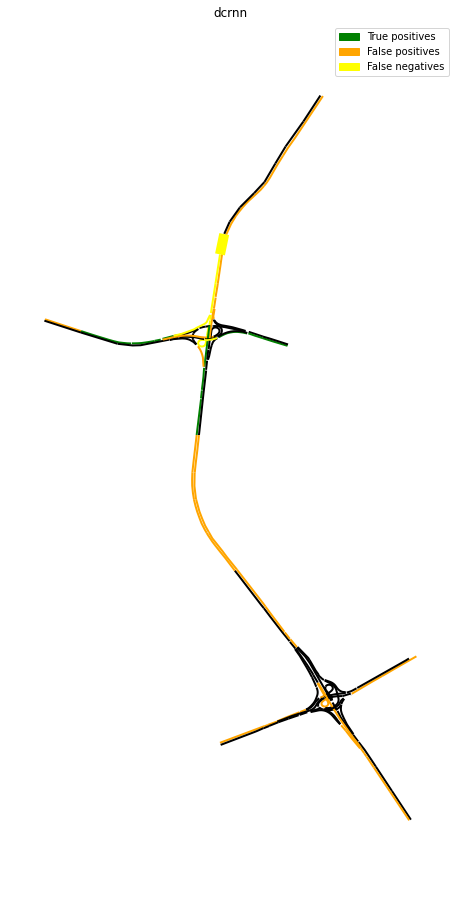

In [96]:
fig, ax = plt.subplots(figsize=(8,16))
plot_classification_errors(y_hat=results_dict[focus_model][41],
y_true=y_true,
seq_num=6,
incident_info=test_dataset.incident_info,
ind_to_edge=ind_to_edge,
net=net,
ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'dcrnn')

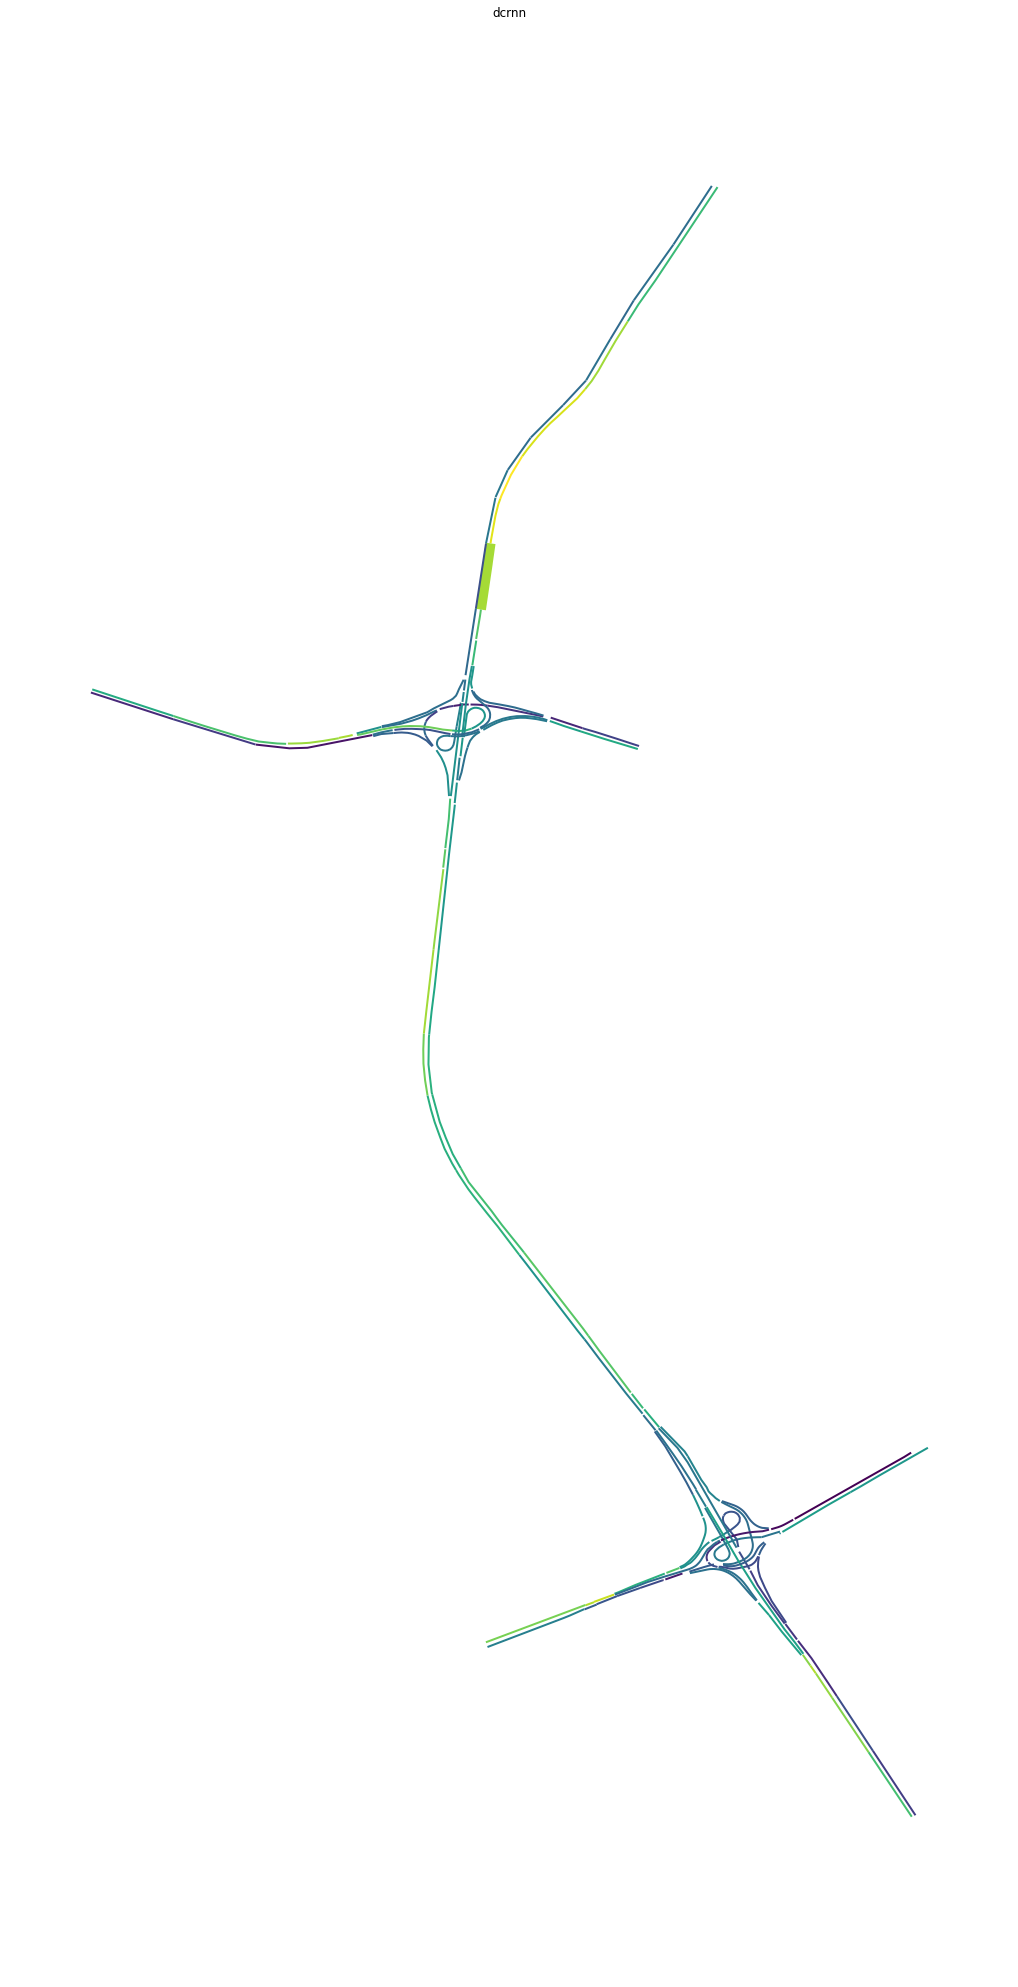

In [101]:
fig, ax = plt.subplots(figsize=(18,36))
plot_net_w_logits(y_hat=results_dict[focus_model][41],
                  seq_num=621,
                  incident_info=test_dataset.incident_info,
                  ind_to_edge=ind_to_edge,
                  net=net,
                  ax=ax)
ax.set_axis_off()
ax.set_title(focus_model)

Text(0.5, 1.0, 'False neg')

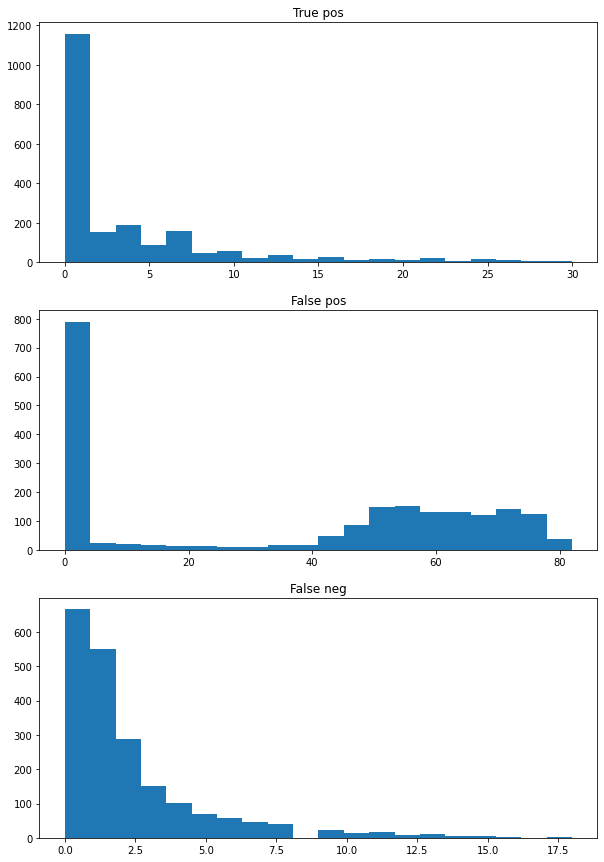

In [98]:
pred_classes = results_dict[focus_model][41][...,0] > 0
true_classes = y_true[...,0]
true_pos = pred_classes * true_classes
false_pos = pred_classes.int() - true_pos.int()
false_neg = true_classes.int() - true_pos.int()

fig, ax = plt.subplots(3, 1, figsize = (10,15))

ax[0].hist(true_pos.sum(1), bins=20)
ax[0].set_title('True pos')

ax[1].hist(false_pos.sum(1), bins=20)
ax[1].set_title('False pos')

ax[2].hist(false_neg.sum(1), bins=20)
ax[2].set_title('False neg')

